<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Preprocess-10X" data-toc-modified-id="Preprocess-10X-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocess 10X</a></span></li><li><span><a href="#Load-10X" data-toc-modified-id="Load-10X-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load 10X</a></span></li><li><span><a href="#Reduce-dimensions" data-toc-modified-id="Reduce-dimensions-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Reduce dimensions</a></span></li><li><span><a href="#Merge-samples" data-toc-modified-id="Merge-samples-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Merge samples</a></span></li></ul></li><li><span><a href="#Main" data-toc-modified-id="Main-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Main</a></span><ul class="toc-item"><li><span><a href="#Load-data-and-preprocess" data-toc-modified-id="Load-data-and-preprocess-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load data and preprocess</a></span></li><li><span><a href="#Create-metadata" data-toc-modified-id="Create-metadata-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Create metadata</a></span></li><li><span><a href="#Reduce-dimensions" data-toc-modified-id="Reduce-dimensions-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Reduce dimensions</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Clustering</a></span></li></ul></li></ul></div>

# Imports

In [111]:
# !pip install phate scprep umap-learn tasklogger magic-impute louvain seaborn
# !pip install git+https://github.com/jacoblevine/phenograph.git
# !pip install jupyter_contrib_nbextensions


In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
import sklearn.cluster
import sklearn.manifold

import scprep
import os
import tasklogger
import phate
import umap

import graphtools as gt
import magic
import phenograph
import louvain

from sklearn.decomposition import PCA


# Functions

## Preprocess 10X

In [113]:
#' This function takes a data-frame (genes x cells), 
#' creates a Scprep object with it and filters the object for default tags such as  
#' Min and max nFeature_RNA and % of MT
#' 
#'
#' @param data data-frame
#' @param percent_mt integer [0-100]
#' @param max_features integer [0-Inf]
#' @param min_features integer [0-Inf]
#' @return Preprocessed Seurat object
#' @export

def preprocess_10X(data, name='10X-project', percent_mt=20, max_features=5000, min_features=200):
    
    #Remove empty cells and empty genes
    data = scprep.filter.filter_empty_cells(data)
    data = scprep.filter.filter_empty_genes(data)
    
    #Remove elements based on mythocondrial percentage
    mt_genes = scprep.select.get_gene_set(data, starts_with=["MT-", "mt-"])
    data = scprep.filter.filter_gene_set_expression(data=data, genes=mt_genes, percentile=100-percent_mt, keep_cells='below')
    
    #Remove elements based on number of cell and number of features
    data = scprep.filter.filter_library_size(data=data, cutoff=(min_features, max_features), keep_cells='between')
    data = scprep.filter.filter_rare_genes(data=data, cutoff=0, min_cells=3)

    return data

## Load 10X

In [114]:
# This function takes the path to a 10X output folder and instanciates the Scprep object
#
# @param file string (path to file)
# @param percent_mt integer [0-100]
# @param max_features integer [0-Inf]
# @param min_features integer [0-Inf]
# @return Preprocessed Seurat object
# @export

def load_10X(dir_path, name='10X-project',percent_mt=20, max_features=5000, min_features=200):
    data = scprep.io.load_10X(dir_path, sparse=True, gene_labels='both')
    return preprocess_10X(data=data, percent_mt=percent_mt, max_features=max_features, min_features=min_features)


## Reduce dimensions

In [115]:
# This function reduces the dimensions of the Normalized Seurat object
# Runs PCA and then UMAP and then performs clustering

# @param seurat.obj S4 instance
# @param ndims integer [3-100]
# @param res double [0-3]
# @return Seurat object with reduction embeddings
# @export

def reduce_dim(data, ndims=15, res=.1):
    data = scprep.normalize.library_size_normalize(data)
    data = scprep.utils.matrix_transform(data, np.sqrt)


    return data

## Merge samples

In [116]:
# This function allows to instantiate a merged Seurat object of several distinct samples
# 
#
# @param files character vector of the files to merge 
# @return Merged Seurat object 
# @export

def merge_samples(dir_paths, labels, name='10X-project',percent_mt=20, max_features=5000, min_features=200):
    
    # Declare empty array T
    T=[]
    
    #Loading all files
    for dp in dir_paths:
        T.append(scprep.io.load_10X(dp, sparse=True, gene_labels='both'))
        
    #Merge samples
    data, sample_labels = scprep.utils.combine_batches(
        data=T,
        batch_labels=labels,
        append_to_cell_names=True
    )
    
    # Delete T to save space
    for t in T:
        del t

    return preprocess_10X(data, name, percent_mt, max_features, min_features), sample_labels

## Load gene markers

In [117]:
# This function takes the path to tsv file (typically from panglaodb)
# outputs a dataframe of the loaded data
#
# @param file string (path to file)
# @param file seperator (ex: '\t' for tsv)
# returns load pandaDF

def load_gene_markers(file_path, file_seperator):
    return pd.read_csv(file_path, file_seperator)

## Get gene markers from cell type

In [118]:
# This function takes a cell type, and returns all associated markers (in title form)
#
# @param target dataframe
# @param cell type (exact string)
# returns array of marker strings

def get_cell_type_markers(marker_dataframe, cell_type):
    cell_type_subset_df = marker_dataframe[marker_dataframe["cell type"] == cell_type]
    markers =cell_type_subset_df["official gene symbol"].tolist()
    return [m.title() for m in markers]

# Main

## Load data and preprocess

In [119]:

dir_paths = [
    "../data/14_EAE_all_cells.MPS12344479-A02.sorted.1229.merged.10x_outputs/filtered_feature_bc_matrix",
    "../data/15_EAE_all_cells.MPS12344479-B02.sorted.1229.merged.10x_outputs/filtered_feature_bc_matrix",
    "../data/16_WT_all_cells.MPS12344479-H01.sorted.1229.merged.10x_outputs/filtered_feature_bc_matrix"
]

lables = [
    "14_EAE", 
    "15_EAE", 
    "16_WT"
]

data,sample_labels = merge_samples(dir_paths=dir_paths, labels=lables, percent_mt=20, max_features=5000, min_features=200)

# seurat_path = "../../tutorials/seurat_guidedClustering/seurat_clusteringTutorial/filtered_gene_bc_matrices/hg19"
# data = load_10X(dir_path=seurat_path, percent_mt=20, max_features=5000, min_features=200)
data.head()


,0610005C13Rik (ENSMUSG00000109644),0610009B22Rik (ENSMUSG00000007777),0610009O20Rik (ENSMUSG00000024442),0610010F05Rik (ENSMUSG00000042208),0610010K14Rik (ENSMUSG00000020831),0610012G03Rik (ENSMUSG00000107002),0610025J13Rik (ENSMUSG00000046683),0610030E20Rik (ENSMUSG00000058706),0610037L13Rik (ENSMUSG00000028608),0610038B21Rik (ENSMUSG00000097882),...,mt-Co2 (ENSMUSG00000064354),mt-Co3 (ENSMUSG00000064358),mt-Cytb (ENSMUSG00000064370),mt-Nd1 (ENSMUSG00000064341),mt-Nd2 (ENSMUSG00000064345),mt-Nd3 (ENSMUSG00000064360),mt-Nd4 (ENSMUSG00000064363),mt-Nd4l (ENSMUSG00000065947),mt-Nd5 (ENSMUSG00000064367),mt-Nd6 (ENSMUSG00000064368)
AAACCTGGTATCGCAT-1_14_EAE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,9.0,5.0,2.0,2.0,1.0,1.0,8.0,0.0,0.0
AAACGGGAGAACTGTA-1_14_EAE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,5.0,6.0,6.0,3.0,0.0,1.0,4.0,1.0,0.0
AAACGGGGTTCTCATT-1_14_EAE,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,7.0,9.0,8.0,4.0,6.0,1.0,3.0,17.0,0.0,1.0
AAACGGGGTTCTGAAC-1_14_EAE,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,13.0,15.0,10.0,3.0,6.0,0.0,4.0,18.0,2.0,0.0
AAAGATGCAATGACCT-1_14_EAE,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,26.0,12.0,20.0,6.0,5.0,1.0,2.0,18.0,3.0,1.0


## Create metadata

In [120]:
sample_labels = pd.Series(sample_labels, index=data.index, name = "sample_labels")

libsize = scprep.measure.library_size(data)
libsize.name='library_size'

metadata = pd.concat([sample_labels, libsize], axis=1)
metadata


,sample_labels,library_size
AAACCTGGTATCGCAT-1_14_EAE,14_EAE,2460.0
AAACGGGAGAACTGTA-1_14_EAE,14_EAE,1154.0
AAACGGGGTTCTCATT-1_14_EAE,14_EAE,3949.0
AAACGGGGTTCTGAAC-1_14_EAE,14_EAE,4312.0
AAAGATGCAATGACCT-1_14_EAE,14_EAE,4120.0
...,...,...
TTTGTCACACGACGAA-1_16_WT,16_WT,4019.0
TTTGTCAGTGGCGAAT-1_16_WT,16_WT,2084.0
TTTGTCATCAGTTAGC-1_16_WT,16_WT,3603.0
TTTGTCATCATATCGG-1_16_WT,16_WT,2399.0


## Load gene markers to dataframe

In [121]:
gene_markers = load_gene_markers("../data/gene_bank/PanglaoDB_markers_27_Mar_2020.tsv", "\t")

## Reduce dimensions

In [122]:
reduce_dim(data)

,0610005C13Rik (ENSMUSG00000109644),0610009B22Rik (ENSMUSG00000007777),0610009O20Rik (ENSMUSG00000024442),0610010F05Rik (ENSMUSG00000042208),0610010K14Rik (ENSMUSG00000020831),0610012G03Rik (ENSMUSG00000107002),0610025J13Rik (ENSMUSG00000046683),0610030E20Rik (ENSMUSG00000058706),0610037L13Rik (ENSMUSG00000028608),0610038B21Rik (ENSMUSG00000097882),...,mt-Co2 (ENSMUSG00000064354),mt-Co3 (ENSMUSG00000064358),mt-Cytb (ENSMUSG00000064370),mt-Nd1 (ENSMUSG00000064341),mt-Nd2 (ENSMUSG00000064345),mt-Nd3 (ENSMUSG00000064360),mt-Nd4 (ENSMUSG00000064363),mt-Nd4l (ENSMUSG00000065947),mt-Nd5 (ENSMUSG00000064367),mt-Nd6 (ENSMUSG00000064368)
AAACCTGGTATCGCAT-1_14_EAE,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,3.492151,6.048584,4.508348,2.851330,2.851330,2.016195,2.016195,5.702659,0.000000,0.000000
AAACGGGAGAACTGTA-1_14_EAE,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,5.887448,6.582367,7.210622,7.210622,5.098680,0.000000,2.943724,5.887448,2.943724,0.000000
AAACGGGGTTCTCATT-1_14_EAE,0.0,0.00000,0.0,0.0,0.000000,1.591316,0.0,0.000000,0.0,0.0,...,4.210226,4.773948,4.500921,3.182632,3.897912,1.591316,2.756240,6.561164,0.000000,1.591316
AAACGGGGTTCTGAAC-1_14_EAE,0.0,0.00000,0.0,0.0,0.000000,1.522862,0.0,0.000000,0.0,0.0,...,5.490758,5.898020,4.815713,2.637675,3.730235,0.000000,3.045725,6.460957,2.153652,0.000000
AAAGATGCAATGACCT-1_14_EAE,0.0,0.00000,0.0,0.0,1.557942,0.000000,0.0,1.557942,0.0,0.0,...,7.943979,5.396871,6.967330,3.816164,3.483665,1.557942,2.203263,6.609790,2.698435,1.557942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACACGACGAA-1_16_WT,0.0,0.00000,0.0,0.0,1.577397,1.577397,0.0,0.000000,0.0,0.0,...,3.527167,1.577397,3.863818,1.577397,1.577397,0.000000,0.000000,4.173400,2.230776,0.000000
TTTGTCAGTGGCGAAT-1_16_WT,0.0,2.19054,0.0,0.0,0.000000,3.794126,0.0,0.000000,0.0,0.0,...,4.898196,3.794126,3.097891,2.190540,0.000000,0.000000,2.190540,3.794126,2.190540,2.190540
TTTGTCATCAGTTAGC-1_16_WT,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,3.725228,4.407749,2.885549,1.665973,0.000000,0.000000,0.000000,2.885549,1.665973,0.000000
TTTGTCATCATATCGG-1_16_WT,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,4.565306,4.565306,6.125001,5.401743,5.001042,0.000000,0.000000,6.771443,2.041667,2.041667


## Clustering

In [123]:
# Obtain PCA and singular values
data_pca, singular_values = scprep.reduce.pca(data, n_components=100, return_singular_values=True, method='dense')
data_pca = pd.DataFrame(data_pca, index=data.index)

In [124]:
# Obtain phate data
data_phate = phate.PHATE().fit_transform(data)
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 9613 observations and 17684 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 20.63 seconds.
    Calculating KNN search...
    Calculated KNN search in 16.65 seconds.
    Calculating affinities...
    Calculated affinities in 0.34 seconds.
  Calculated graph and diffusion operator in 38.34 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.47 seconds.
    Calculating KMeans...
    Calculated KMeans in 31.11 seconds.
  Calculated landmark operator in 36.45 seconds.
  Calculating optimal t...
    Automatically selected t = 40
  Calculated optimal t in 5.32 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.51 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.06 seconds.
Calculated PHATE in 89.70 seconds.


In [125]:
# Obtain umap data
data_umap = umap.UMAP().fit_transform(data)
data_umap = pd.DataFrame(data_umap, index=data.index)

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

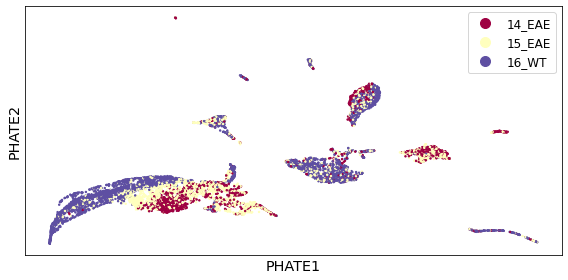

In [126]:
# Display UMAP for all samples
scprep.plot.scatter2d(data_umap, c=metadata['sample_labels'], figsize=(8,4), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

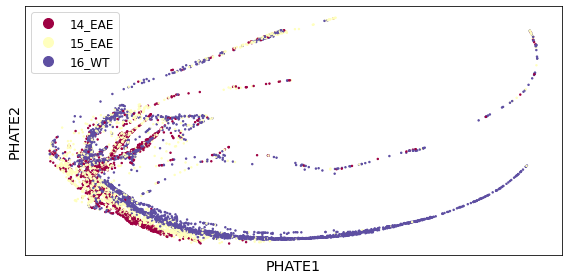

In [127]:
# Display PHATE for all samples
scprep.plot.scatter2d(data_phate, c=metadata['sample_labels'], figsize=(8,4), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

In [128]:
# Obtain clusters from umap data

kmeans_clusters = sklearn.cluster.KMeans(n_clusters=20).fit_predict(data_umap)

<AxesSubplot:title={'center':'Clusters according to umap'}, xlabel='0', ylabel='1'>

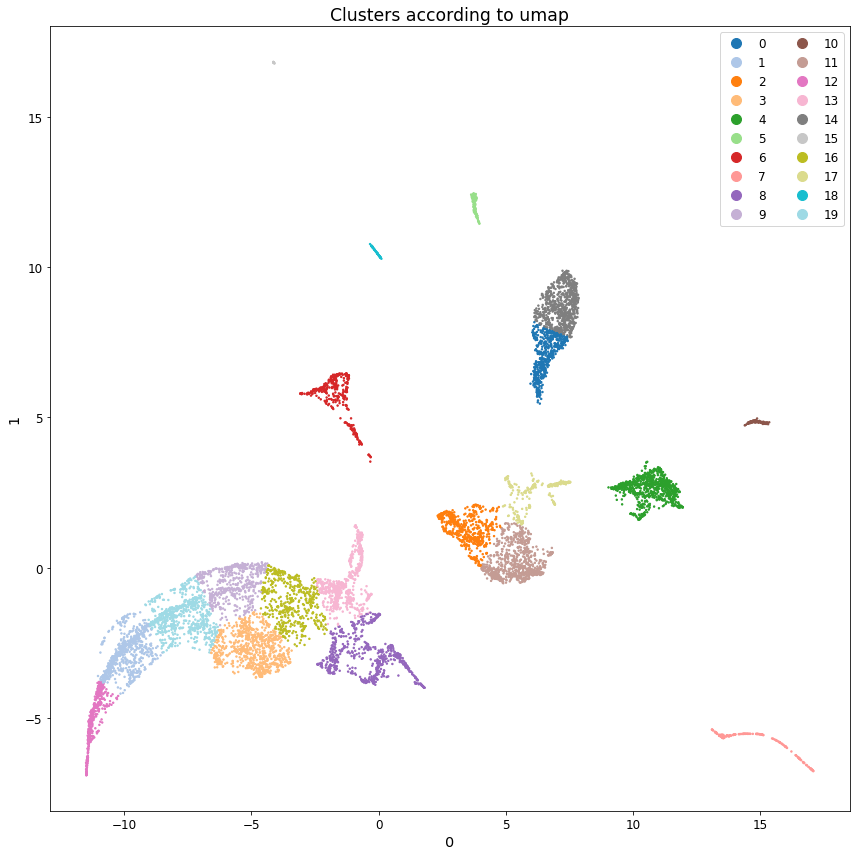

In [129]:
# Plot clusters

scprep.plot.scatter2d(data_umap, c=kmeans_clusters,figsize=(12, 12),  title="Clusters according to umap")

In [130]:
# Choroid plexus gene dataset 

# choroid_genes = ['Kl', 'Ttr', 'Sostdc1', 'Clic6', 'Slc16a2', 
#                       'Slc4a10', 'Htr2c', 'Aqp1', 'Slc4a2', 'Slc4a5', 
#                       'Slc31a1', 'Car12', 'Cldn2', 'Slc13a4', 'Slc29a4', 
#                       'Prlr', 'Cldn1', 'Slc2a12', 'Wfikkn2', 'Slc23a2', 
#                       'Slc26a11', 'Chmp1a']
choroid_genes = get_cell_type_markers(gene_markers, "Choroid plexus cells")
ependymal_genes = get_cell_type_markers(gene_markers, "Ependymal cells")

ependymal_genes



['Foxj1',
 'Trim71',
 'Six3',
 'Usp18',
 'Cetn4',
 'Aqp4',
 'Celsr2',
 'Aqp1',
 'Gfap',
 'Enkur',
 'Fam216B',
 'Krt15',
 'Catip',
 'Dnah12',
 'Fam166B',
 'Iqcg',
 'Spef2',
 'Rabl2',
 'Myo16',
 'Odf3B',
 'Plxnb2',
 'Tekt1',
 'Chek2',
 'Crocc',
 'Nme9',
 'Cfap126',
 'Meig1',
 'Hspa2',
 'Cfap65',
 'Lrrc23',
 'Tekt4',
 'Calml4',
 'Pifo',
 'Crygn',
 'Hdc',
 'Fam183B',
 'Pcp4L1',
 'Dynlrb2',
 'Tmem107',
 'Riiad1',
 'Tmem212',
 'Rsph1',
 'Ccdc153',
 'S100B',
 'Ak7',
 'Rarres2',
 'Pvalb',
 'Angptl2',
 'Cfap54',
 'Stoml3',
 'Pltp',
 'Sspo',
 'Efnb3',
 'Myb',
 'Rfx2',
 'Zmynd10',
 'Ak8',
 'Cfap44',
 'Tm4Sf1']

c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\scprep\select.py:444: UserWarning: Selecting 0 columns.
  warnings.warn("Selecting 0 columns.", UserWarning)


Gene Trim71 is not in samples


c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\scprep\select.py:444: UserWarning: Selecting 0 columns.
  warnings.warn("Selecting 0 columns.", UserWarning)


Gene Fam216B is not in samples


c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\scprep\select.py:444: UserWarning: Selecting 0 columns.
  warnings.warn("Selecting 0 columns.", UserWarning)


Gene Fam166B is not in samples


c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\scprep\select.py:444: UserWarning: Selecting 0 columns.
  warnings.warn("Selecting 0 columns.", UserWarning)


Gene Odf3B is not in samples


c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\scprep\select.py:444: UserWarning: Selecting 0 columns.
  warnings.warn("Selecting 0 columns.", UserWarning)
c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\scprep\select.py:444: UserWarning: Selecting 0 columns.
  warnings.warn("Selecting 0 columns.", UserWarning)


Gene Fam183B is not in samples
Gene Pcp4L1 is not in samples


c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\scprep\select.py:444: UserWarning: Selecting 0 columns.
  warnings.warn("Selecting 0 columns.", UserWarning)


Gene S100B is not in samples


c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\scprep\select.py:444: UserWarning: Selecting 0 columns.
  warnings.warn("Selecting 0 columns.", UserWarning)


Gene Tm4Sf1 is not in samples


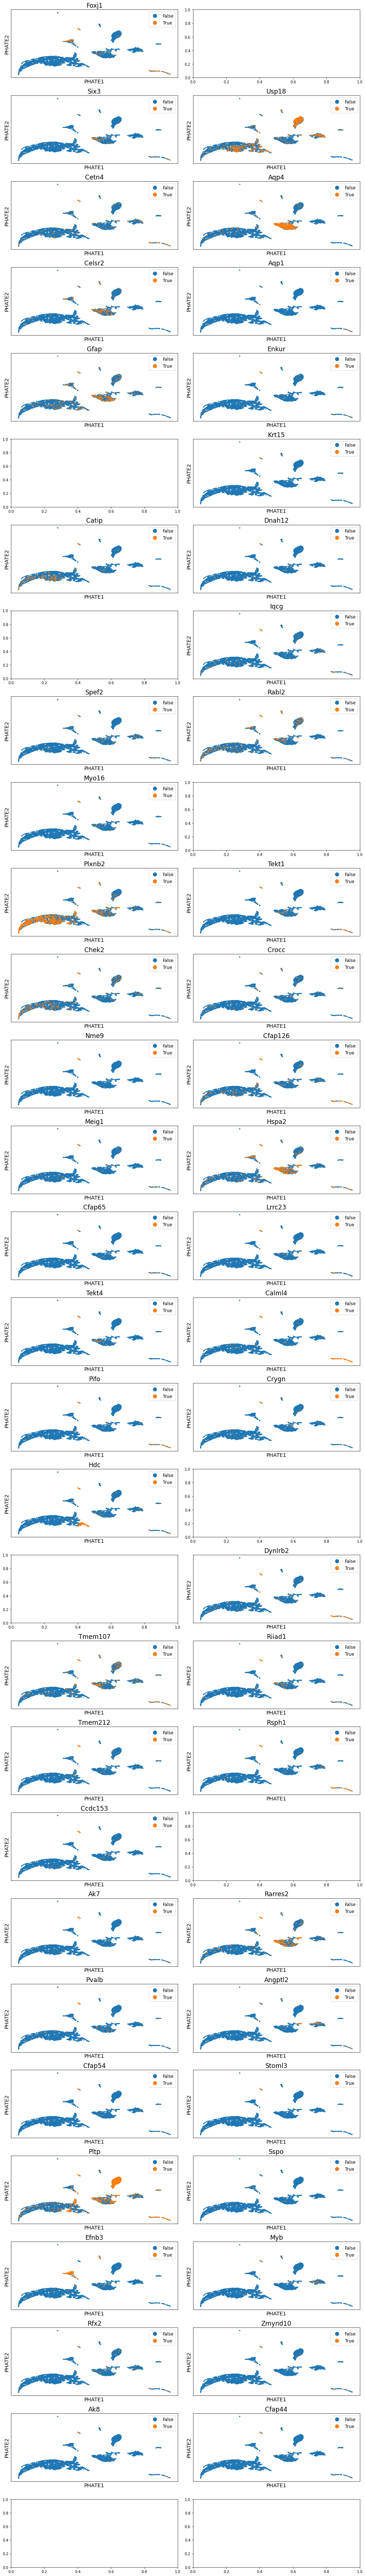

In [144]:
# Plot genes on umap



genes_for_plotting = ependymal_genes

n_cols = 2
n_rows = round(len(genes_for_plotting)/2)

fig, axes = plt.subplots(n_rows ,n_cols, figsize=(14,98))
for curr_gene, ax in zip(genes_for_plotting, axes.flatten()):
    
    # What cells contain an expression of this gene?
    try:
        expression = scprep.select.select_cols(data, exact_word=curr_gene)

        sort_index = expression.sort_values().index

        scprep.plot.scatter2d(data_umap.loc[sort_index], c=expression.loc[sort_index] > 0, shuffle=False,
                             title=curr_gene, ticks=None, label_prefix='PHATE', ax=ax)
    except:
        print("Gene {} is not in samples".format(curr_gene))
fig.tight_layout()

# np.set_printoptions(threshold=np.inf)
# data.columns.values

In [ ]:
# Assign cluster number to each cell

kmeans_umap_clusters = pd.Series(kmeans_clusters, index=data.index, name = "kmeans_umap_clusters")

metadata = pd.concat([metadata, kmeans_umap_clusters], axis=1)
metadata

In [ ]:
# Extracting appropriate subset

choroid_cell_cluster = 6

choroid_cell_cluster_names = metadata[metadata["kmeans_umap_clusters"] == choroid_cell_cluster].index

data_choroid = data.loc[choroid_cell_cluster_names]
# print(metadata[metadata["kmeans_umap_clusters"] == choroid_cell_cluster].index)
# data_choroid = umap_cluster_data[umap_cluster_data["kmeans_umap_clusters"] == choroid_cell_cluster]

# scprep.plot.scatter2d(data_umap, c=umap_cluster_data["kmeans_umap_clusters"] == choroid_cell_cluster, figsize=(8,4), cmap="Spectral",
#                       ticks=False, label_prefix="PHATE")


# data_choroid


In [ ]:
# Obtain phate data
data_phate = phate.PHATE(t=25).fit_transform(data_choroid)
data_phate = pd.DataFrame(data_phate, index=data_choroid.index)

In [ ]:
# Display PHATE for choroid data

scprep.plot.scatter2d(data_phate,figsize=(8,4), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

# Data moein

In [ ]:
moein_data = scprep.io.load_csv("moein.data.csv", cell_axis="column")
moein_data

In [ ]:
data_phate = phate.PHATE(t=25).fit_transform(moein_data)


In [ ]:
data_phate = pd.DataFrame(data_phate, index=moein_data.index)
data_phate

In [ ]:
# Display PHATE for moein data

scprep.plot.scatter2d(data_phate,figsize=(12,12), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")